In [1]:
BATCH_SIZE = 4
output_path = 'output_201902212007/'
weight_save_path = "output_201902212007/"

In [2]:
import pandas as pd
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
% matplotlib inline
import os
from utils import *

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

ship_dir = '../ship_detection/data'
train_image_dir = os.path.join(ship_dir, 'train_v2')
test_image_dir = os.path.join(ship_dir, 'test_v2')

In [3]:
def make_image_gen(in_df, batch_size = BATCH_SIZE):
    all_batches = list(in_df.groupby('ImageId'))
    out_rgb = []
    out_mask = []
    while True:
        np.random.shuffle(all_batches)
        for c_img_id, c_masks in all_batches:
            rgb_path = os.path.join(train_image_dir, c_img_id)
            c_img = imread(rgb_path)
            c_mask = np.expand_dims(masks_as_image(c_masks['EncodedPixels'].values), -1)
            out_rgb += [c_img]
            out_mask += [c_mask]
            if len(out_rgb)>=batch_size:
                yield np.stack(out_rgb, 0)/255.0, np.stack(out_mask, 0)
                out_rgb, out_mask=[], []

In [4]:
valid_df = pd.read_csv('valid_df.csv')
valid_gen = make_image_gen(valid_df, len(valid_df))
valid_x, valid_y = next(valid_gen)
print(valid_x.shape, valid_y.shape)

(1676, 768, 768, 3) (1676, 768, 768, 1)


In [5]:
from segmentation_models import FPN

seg_model = FPN('resnet34')

weight_path = output_path+'seg_model_weights.best.hdf5'
seg_model.load_weights(weight_path)

/home/pami2/anaconda2/envs/chaos/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/pami2/anaconda2/envs/chaos/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/pami2/anaconda2/envs/chaos/lib/python3.6/site-packages/image_classifiers-0.2.0-py3.6.egg/classification_models/resnext/__init__.py:4: UserWarning: Current ResNext models are deprecated, use keras.applications ResNeXt models


In [6]:
class TTA_ModelWrapper():
    """A simple TTA wrapper for keras computer vision models.
    Args:
        model (keras model): A fitted keras model with a predict method.
    """

    def __init__(self, model):
        self.model = model

    def predict(self, X, verbose=1):
        """Wraps the predict method of the provided model.
        Augments the testdata with horizontal and vertical flips and
        averages the results.
        Args:
            X (numpy array of dim 4): The data to get predictions for.
        """
        p0 = self.model.predict(X, batch_size=BATCH_SIZE, verbose=verbose)
        p1 = self.model.predict(np.fliplr(X), batch_size=BATCH_SIZE, verbose=verbose)
        p2 = self.model.predict(np.flipud(X), batch_size=BATCH_SIZE, verbose=verbose)
        p3 = self.model.predict(np.transpose(X, (0, 2, 1, 3)), batch_size=BATCH_SIZE, verbose=verbose)
        p4 = self.model.predict(np.rot90(X, 1, (1, 2)), batch_size=BATCH_SIZE, verbose=verbose)
        p5 = self.model.predict(np.rot90(X, 2, (1, 2)), batch_size=BATCH_SIZE, verbose=verbose)
        p6 = self.model.predict(np.rot90(X, 3, (1, 2)), batch_size=BATCH_SIZE, verbose=verbose)
        p7 = self.model.predict(np.rot90(np.transpose(X, (0, 2, 1, 3)), 2), batch_size=BATCH_SIZE, verbose=verbose)
        #         print(p7.shape)
        #         print(np.rot90(np.transpose(p7),2).shape)
        p = (p0 +
             (np.fliplr(p1)) +
             (np.flipud(p2)) +
             (np.transpose(p3, (0, 2, 1, 3))) +
             (np.rot90(p4, 3, (1, 2))) +
             (np.rot90(p5, 2, (1, 2))) +
             (np.rot90(p6, 1, (1, 2))) +
             (np.rot90(np.transpose(p7, (0, 2, 1, 3)), 2))
             ) / 8

        return p

    def _expand(self, x):
        return np.expand_dims(x, axis=0)

In [7]:
tta_model = TTA_ModelWrapper(seg_model)
pred_y = tta_model.predict(valid_x)

print(pred_y.shape, pred_y.min(), pred_y.max(), pred_y.mean())

1676/1676 [==============================] - 130s 77ms/step
(1676, 768, 768, 1) 1.502016e-19 0.99999994 0.005928366


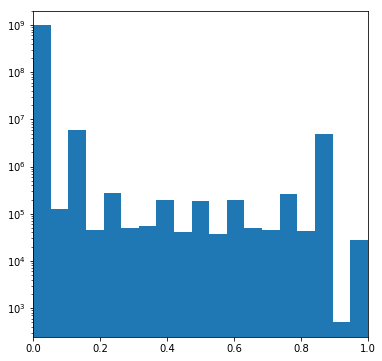

In [8]:
fig, ax = plt.subplots(1, 1, figsize = (6, 6))
ax.hist(pred_y.ravel(), np.linspace(0, 1, 20))
ax.set_xlim(0, 1)
ax.set_yscale('log', nonposy='clip')

In [9]:
# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

In [10]:
from tqdm import tqdm_notebook

thresholds = np.linspace(0, 1, 50)
ious = np.array([iou_metric_batch(valid_y, np.int32(pred_y > threshold)) for threshold in tqdm_notebook(thresholds)])

A Jupyter Widget

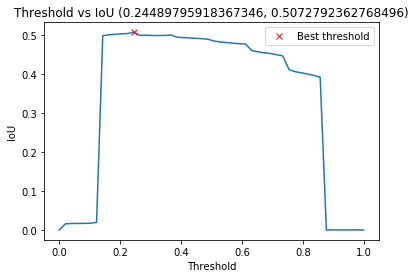

In [11]:
threshold_best_index = np.argmax(ious)
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]
plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

In [12]:
from skimage.morphology import label

tta_model = TTA_ModelWrapper(seg_model)
def predict(img, path=test_image_dir):
    c_img = imread(os.path.join(path, img))
    c_img = np.expand_dims(c_img, 0)/255.0
    cur_seg = tta_model.predict(c_img,0)
    cur_seg = np.array(np.round(cur_seg[0,:,:,:] > threshold_best), dtype=np.float32)
    return cur_seg, c_img

In [13]:
boat_df = pd.read_csv("../ship_detection/output/ship_detection_lafoss.csv")
is_boat = boat_df.p_ship>0.5
print('Found {} boats'.format(is_boat.sum()))
boat_df.head()

Found 3318 boats


,id,p_ship
0,51e9beaca.jpg,0.053764
1,0a4d97295.jpg,0.412521
2,c175e03b9.jpg,0.007387
3,8a56c9bdd.jpg,0.999422
4,f52f4a484.jpg,0.000480


In [14]:
# test_paths = np.array(os.listdir(test_image_dir))
# print(len(test_paths), 'test images found')

In [15]:
from tqdm import tqdm_notebook

def pred_encode(img, **kwargs):
    cur_seg, _ = predict(img)
    cur_rles = multi_rle_encode(cur_seg, **kwargs)
    return [[img, rle] for rle in cur_rles if rle is not None]

out_pred_rows = []
for c_img_name in tqdm_notebook(boat_df.id[is_boat]):   #boat_df.id[is_boat]  test_paths
    out_pred_rows += pred_encode(c_img_name)

A Jupyter Widget

In [16]:
sub = pd.DataFrame(out_pred_rows)
sub.columns = ['ImageId', 'EncodedPixels']
sub = sub[sub.EncodedPixels.notnull()]
sub.head()

,ImageId,EncodedPixels
0,8a56c9bdd.jpg,131619 1 132384 8 133151 12 133918 17 134685 2...
1,c0761cc48.jpg,122591 3 123357 7 124123 10 124890 12 125656 1...
2,da002eb00.jpg,149670 4 150437 7 151204 9 151971 11 152738 12...
3,e1a547a79.jpg,463518 5 464285 8 465052 9 465820 11 466587 12...
4,c2ee51c02.jpg,480203 5 480970 8 481737 11 482505 14 483272 1...


In [17]:
sub1 = pd.read_csv('../ship_detection/data/sample_submission_v2.csv')
sub1 = pd.DataFrame(np.setdiff1d(sub1['ImageId'].unique(), sub['ImageId'].unique(), assume_unique=True), columns=['ImageId'])
sub1['EncodedPixels'] = None
print(len(sub1), len(sub))

sub = pd.concat([sub, sub1])
print(len(sub))

sub.to_csv(output_path+'submission'+'.csv', 
              index=False)
sub.head()

12606 5186
17792


,ImageId,EncodedPixels
0,8a56c9bdd.jpg,131619 1 132384 8 133151 12 133918 17 134685 2...
1,c0761cc48.jpg,122591 3 123357 7 124123 10 124890 12 125656 1...
2,da002eb00.jpg,149670 4 150437 7 151204 9 151971 11 152738 12...
3,e1a547a79.jpg,463518 5 464285 8 465052 9 465820 11 466587 12...
4,c2ee51c02.jpg,480203 5 480970 8 481737 11 482505 14 483272 1...
